# Sound Event Detection (обнаружение звуковых событий)

**Задача.**

Вам нужно натренировать модель для задачи детекции звуковых ивентов, прогнать полученную модель на тестовых данных и загрузить полученный результат в формате tsv в Яндекс.Контест.

Данные для задачи можно скачать по ссылке: https://disk.yandex.ru/d/gcGKZ_KsXZN4VA.

## Предобработка данных

Импортим необходимые библиотеки и загружаем данные.

In [1]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib

from IPython.display import clear_output

%matplotlib inline

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/gcGKZ_KsXZN4VA'
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))

response = requests.get(final_url)
download_url = response.json()['href']

!wget -O data.tar.gz "{download_url}"
!tar -xf data.tar.gz

Выходные данные были обрезаны до нескольких последних строк (5000).
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.appl

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DATADIR = 'ml_trains_data'
LOADER_WORKERS = 0

In [5]:
DEVICE

device(type='cuda')

In [6]:
class Dataset(torch_data.Dataset):
    def __init__(self, split_part: str, datadir: str, feats: nn.Module, read_labels=True):
        super().__init__()
        data = pd.read_csv(os.path.join(datadir, f'{split_part}.tsv'), sep='\t')
        labels = {}
        if read_labels:
            labels = {key: idx for idx, key in enumerate(sorted(set(data.label.values)))}
            self._idx_to_label = {idx: key for idx, key in enumerate(sorted(set(data.label.values)))}
        self._classes = len(labels)
        self._feats = feats
        self._ytids = []
        self._pathes = []
        self._labels = []
        for _, row in data.iterrows():
            path = os.path.join(datadir, 'clips', f'{row.YTID}.flac')
            if os.path.exists(path):
                self._ytids.append(row.YTID)
                self._pathes.append(path)
                self._labels.append(labels[row.label] if read_labels else 0)

    def __getitem__(self, index):
        try:
            waveform, sample_rate = torchaudio.load(self._pathes[index])
        except Exception as err:
            logging.error("Can't read file %s", self._pathes[index])
            raise err
        assert sample_rate == 16000
        assert waveform.shape[0] == 1
        feats = self._feats(waveform)[0]
        return (feats, self._labels[index])

    def __len__(self) -> int:
        return len(self._pathes)

    def classes(self) -> int:
        return self._classes


def collate_fn(batch):
    max_length = max(item[0].shape[1] for item in batch)
    X = torch.zeros((len(batch), batch[0][0].shape[0], max_length))
    for idx, item in enumerate(batch):
        X[idx, :, :item[0].shape[1]] = item[0]
    targets = torch.tensor([item[1] for item in batch], dtype=torch.long).reshape(len(batch), 1)
    return (X, targets)

Посмотрим, как выглядят данные:

In [9]:
import pandas as pd

eval = pd.read_csv('ml_trains_data/eval.tsv', sep='\t')
train = pd.read_csv('ml_trains_data/train.tsv', sep='\t')

eval.head()

,YTID
0,_oDTEjyE75U_40000
1,5A-8VUzAC1M_180000
2,2sfvzpI4MPE_50000
3,M6w5HD8YIsY_60000
4,4IEpPBzMCN4_10000


In [10]:
train.head()

,YTID,label
0,4i1aizhCnfg_30000,Music
1,G3y5z37XW8E_200000,Water
2,1imx8d_Ec_4_40000,"Child speech, kid speaking"
3,FJoR8b-lTgY_30000,Engine
4,BDH7Fx1APR8_40000,Music


### Feats part

In [7]:
import torchaudio.transforms as T
import torch
import torch.nn as nn

class LogMelSpectrogram(nn.Module):
    def __init__(self, sample_rate=16000, n_mels=40, n_fft=400, hop_length=160):
        """
        :param sample_rate: Частота выборки сигнала
        :param n_mels: Число мел-фильтров
        :param n_fft: Размер окна FFT
        :param hop_length: Шаг окна
        """
        super(LogMelSpectrogram, self).__init__()
        self.melspectrogram = T.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels,power=2.0)
        self.amplitude_to_db = T.AmplitudeToDB(top_db=80)

    def forward(self, waveform):
        """
        Преобразует входной сигнал в логарифмическую мел-спектрограмму.
        :param waveform: [1, T] - одномерный аудиосигнал
        :return: Логарифмическая мел-спектрограмма [n_mels, time]
        """
        mel_spec = self.melspectrogram(waveform)  # [n_mels, time]
        log_mel_spec = self.amplitude_to_db(mel_spec)  # Преобразуем в логарифмический масштаб
        return log_mel_spec

# FBANK 40 by default, but you can choose something else
FEATS = 40
transform = LogMelSpectrogram(n_mels=FEATS)
trainset = Dataset('train', 'ml_trains_data', transform)
testset = Dataset('eval', 'ml_trains_data', transform, read_labels=False)
N_CLASSES = trainset.classes()
assert N_CLASSES == 30

### Eval part

Write balanced accuracy:
$$BAcc = \frac{1}{classes}\sum_{c = 1}^{classes} \frac{\sum_i^n I(y_i = p_i = c)}{\sum_i^n I(y_i = c)}$$

Where:
- $y_i$ -- target class for $i$ element
- $p_i$ -- predicted class for $i$ element

In [8]:
# Get list of pairs (target_class, predicted_class)
def balanced_accuracy(items: list[tuple[int, int]], classes=N_CLASSES) -> float:
    true_pos = np.zeros(classes)
    total = np.zeros(classes)
    for true, pred in items:
        total[true] += 1
        if true == pred:
            true_pos[true] += 1
    return np.mean([true_pos[i] / total[i] if total[i] > 0 else 0 for i in range(classes)])

In [9]:
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 1)], 2), 1.0)
assert np.isclose(balanced_accuracy([(0, 1), (1, 0)], 2), 0.0)
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 0)], 2), 0.5)
assert np.isclose(balanced_accuracy([(0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (0, 1)], 2), 0.625)
assert np.isclose(balanced_accuracy([(1, 1), (0, 1), (2, 2)], 3), 0.66666666666666)

## Этап обучения
Обучите какую-нибудь модель с максимально возможной сбалансированной точностью

Вы можете обучить любую модель, которую хотите. Единственное ограничение заключается в том, что ее необходимо обучать с нуля на основе данных, предоставленных в задаче. Например, вы можете выбрать модель из:

- DNN
- CNN 1d
- CNN 2d
- Transformer
- RNN
- смеси данных моделей

Подсказки:
- Нет необходимости обучать большие модели для решения этой задачи. 10 миллионов параметров - это больше, чем вам нужно.
- Следите за переобучением, попробуйте добавить дополнение, отсев, пакетную норму, L1 / L2-регуляризацию или что-то еще.
- Используйте объединения или пошаговые инструкции, чтобы уменьшить временную нагрузку. Лучше уменьшать нагрузку постепенно, а не в конце.
- Попробуйте другие функции (mel-spec, log-mel-spec, mfcc).

In [10]:
def stage(
    model: nn.Module,
    data: torch_data.Dataset,
    opt: optim.Optimizer,
    batch_size: int = 256,
    train: bool = True
):
    loader = torch_data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        collate_fn=collate_fn
    )
    if train:
        model.train()
    else:
        model.eval()
    loss_sum, batches = 0.0, 0
    pred_pairs = []
    for X, Y in tqdm.tqdm(loader):
        pred = model.forward(X.to(DEVICE))
        loss = F.cross_entropy(pred.squeeze(), Y.squeeze().to(DEVICE))
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        loss_sum += loss.item()
        batches += 1
        with torch.no_grad():
            pred_pairs.extend(zip(
                Y.data.numpy().reshape(-1),
                torch.argmax(pred, dim=1).cpu().data.numpy().reshape(-1)
            ))
    return loss_sum / batches, balanced_accuracy(pred_pairs)


def train(
    model: nn.Module,
    opt,
    batch_size: int = 256,
    epochs: int = 10,
):
    train_data, val_data = torch.utils.data.random_split(trainset, (0.9, 0.1), generator=torch.Generator().manual_seed(42))
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(epochs):
        train_loss, train_acc = stage(model, train_data, opt, batch_size=batch_size)
        val_loss, val_acc = stage(model, val_data, opt, batch_size=batch_size, train=False)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train')
        axis[0].plot(np.arange(1, epoch + 2), val_losses, label='val')
        axis[1].plot(np.arange(1, epoch + 2), train_accs, label='train')
        axis[1].plot(np.arange(1, epoch + 2), val_accs, label='val')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='Accuracy')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}.')
        print(f'Train loss {train_loss}. Train accuracy {train_acc}.')
        print(f'Test loss {val_loss}. Test accuracy {val_acc}')

**Первая модель. Модель с одним полносвязным слоем.**

In [ ]:
class EasyModel(nn.Module):
    def __init__(self, in_dim=FEATS, out_dim=N_CLASSES):
        super(EasyModel, self).__init__()
        self.in_features = in_dim
        self.out_features = out_dim
        self.fc1 = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        # x.shape = [batch_size, FEATS, TIME]
        batch_size = x.size(0)
        time_dim = x.size(2)

        # Объединяем batch_size и time_dim для обработки
        x = x.permute(0, 2, 1).contiguous()  # [batch_size, TIME, FEATS]

        x = x.view(batch_size * time_dim, self.in_features)
        x = self.fc1(x)
        x = x.view(batch_size, time_dim, self.out_features)  # [batch_size, TIME, N_CLASSES]

        # Суммируем по временной размерности (агрегация)
        x = x.mean(dim=1)  # [batch_size, N_CLASSES]

        return x

In [ ]:
model_1 = EasyModel().to(DEVICE)
opt = optim.Adam(model_1.parameters())
train(model_1, opt)

**Вторая модель. Обычная RNN.**

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, in_dim=FEATS, hidden_dim=128, out_dim=N_CLASSES):
        super(RNNModel, self).__init__()
        self.rnn = nn.GRU(input_size=in_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        # x.shape = [batch_size, FEATS, TIME]
        x = x.permute(0, 2, 1)  # [batch_size, TIME, FEATS]
        _, hidden = self.rnn(x)  # hidden.shape = [1, batch_size, hidden_dim]
        x = hidden.squeeze(0)  # [batch_size, hidden_dim]
        x = self.fc(x)  # [batch_size, N_CLASSES]
        return x

In [ ]:
model_2 = RNNModel().to(DEVICE)
opt = optim.Adam(model_2.parameters(), lr = 0.001)
train(model_2, opt)

**Третья модель. RNN c механизмом внимания.**

In [11]:
class AttentionRNNModel(nn.Module):
    def __init__(self, in_dim=FEATS, hidden_dim=128, out_dim=N_CLASSES):
        super(AttentionRNNModel, self).__init__()
        self.rnn = nn.GRU(
            input_size=in_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.attention = nn.Linear(hidden_dim * 2, 1)  # Attention механизм
        self.fc = nn.Linear(hidden_dim * 2, out_dim)  # Финальный классификатор
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # x.shape = [batch_size, FEATS, TIME]
        x = x.permute(0, 2, 1)  # [batch_size, TIME, FEATS]
        rnn_output, _ = self.rnn(x)  # rnn_output: [batch_size, TIME, hidden_dim * 2]

        # Attention: получаем веса для каждого временного шага
        attention_weights = F.softmax(self.attention(rnn_output), dim=1)  # [batch_size, TIME, 1]

        # Взвешиваем rnn_output по этим весам
        context_vector = torch.sum(attention_weights * rnn_output, dim=1)  # [batch_size, hidden_dim * 2]

        # Dropout перед полносвязным слоем
        context_vector = self.dropout(context_vector)

        # Финальный линейный слой
        output = self.fc(context_vector)  # [batch_size, N_CLASSES]
        return output

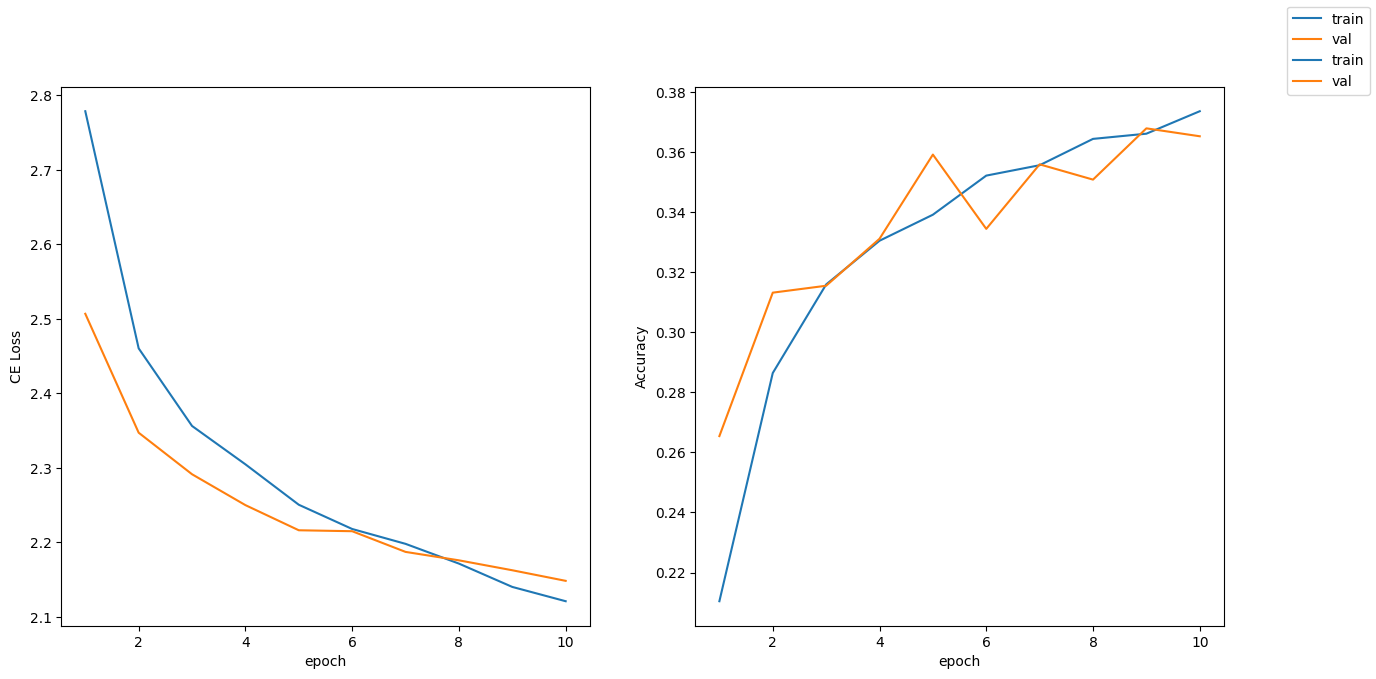

Epoch 10.
Train loss 2.121038354853148. Train accuracy 0.3735658261694198.
Test loss 2.148389447819103. Test accuracy 0.3652273333509847


In [12]:
model_3 = AttentionRNNModel().to(DEVICE)
opt = optim.Adam(model_3.parameters(), lr = 0.003)
train(model_3, opt)

## Часть прогнозирования

Подготовьте файл с результатами и отправьте его на Яндекс.Контест

In [14]:
result = []
for idx, ytid in enumerate(testset._ytids):
    feats, _ = testset[idx]
    predict = torch.argmax(model_3.forward(feats.reshape(1, FEATS, -1).to(DEVICE)), dim=1).item()
    result.append((ytid, trainset._idx_to_label[predict]))
pd.DataFrame(result, columns=['YTID', 'label']).to_csv('result.tsv', sep='\t', index=False)